In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# <center> Ordinary differential equations and physics Part I </center>

In this notes, we shall be comparing two second-order methods: Heun's method and the leapfrog method. As we shall see, these two have very different qualitative behaviour, owing to the fact that the leapfrog method preserves a modified Hamiltonian 'local' to the exact Hamiltonian.

## <center> Exact discrete dynamics of ODE integrators </center>

In this section, we shall be integrating differential equations with a position-dependent acceleration,
\begin{equation}
\ddot{x} = A(x),
\end{equation}
or equivalently
\begin{equation}
\dot{x} = v, \qquad \dot{v} = A(x).
\end{equation}

We shall be numerically integrating this system using two second-order methods. The first is Heun's method, which may be applied to an arbitrary initial value problem,
\begin{equation}
\dot{x} = f(t,x), \qquad x(t_0) = x_0
\end{equation}
with an evolution given by
\begin{equation}
\tilde{x}_{i+1} = x_i + h v_i, \qquad x_{i+1} = x_i + \dfrac{h}{2} \left( f(t_i, x_i) + f(t_{i+1}, \tilde{x}_{i+1} )\right).
\end{equation}
The second is specific to problems with a position-dependent acceleration, called leapfrog integration
\begin{equation}
x_{i+1} = x_i + v_i h + \dfrac{1}{2} A(x_i) h^2, \qquad v_{i+1} = v_i +  \dfrac{1}{2} \left( A(x_i) + A_(x_{i+1}) \right) h.
\end{equation}
As we shall see, even though the two methods are second-order, they have very different qualitative behaviour. It would be hard to prove broad statements about their qualitative differences without involving advanced mathematical methods. Thus, we shall restrict ourselves with solving a very specific problem: the humble harmonic oscillator.

### <center> Numerical integration of the harmonic oscillator </center>

Consider now
\begin{equation}
A(x) = - \omega^2 x, \qquad x(t_0) = x_0, \qquad v(t_0) = v_0.
\end{equation}
This system has the exact solution,
\begin{equation}
x(t) = x_0 \cos \omega t + \dfrac{v_0}{\omega} \sin \omega t.
\end{equation}
In the following numerical integration, let us choose
\begin{equation}
\omega = \pi, \qquad x_0 = 1, \qquad v_0 = 0
\end{equation}

In [11]:
def ho_dt(x):
    """
    Returns the derivatives of x[0] = x, x[1] = v
    """
    dxdt = x[1]
    dvdt = - (np.pi**2) * x[0]
    return np.array([dxdt,dvdt])
    
def heun_int(x, f, h):
    """
    Integration step using heun's method
    """
    f0 = f(x)
    f1 = f(x + h*f0)
    return x + h / 2 * (f0 + f1)

def leapfrog_int(x, h):
    """
    leapfrog integration, assuming harmonic oscillator
    """
    xnew = x[0] + x[1] * h + 0.5 * (- np.pi**2 * x[0]) * h**2
    vnew = x[1] + 0.5 * (- np.pi**2 * x[0] - np.pi**2 * xnew) * h
    return np.array([xnew, vnew])

Let us try to integrate this using $h = 0.1$

In [24]:
def evolution_heun(x, f, h):
    x_new = x
    yield x_new
    
    while True:
        x_new = heun_int(x_new, f, h)
        yield x_new
        
def evolution_lf(x, h):
    x_new = x
    yield x_new
    
    while True:
        x_new = leapfrog_int(x_new, h)
        yield x_new
        
## integration parameters
h = 0.65
T = 200
N = int(T/h) + 1

#initial conditions
x = np.array([1.,0])

##evolution generators
evolve_heun = evolution_heun(x, ho_dt, h)
evolve_lf = evolution_lf(x,h)

t = []
x_traj_heun = []
v_traj_heun = []

x_traj_lf = []
v_traj_lf = []

for k in range(N):
    t.append(k*h)
    
    x_heun = next(evolve_heun)
    x_traj_heun.append(x_heun[0])
    v_traj_heun.append(x_heun[1])
    
    x_lf = next(evolve_lf)
    x_traj_lf.append(x_lf[0])
    v_traj_lf.append(x_lf[1])

Let us plot the evolution of the harmonic oscillator for the two methods.

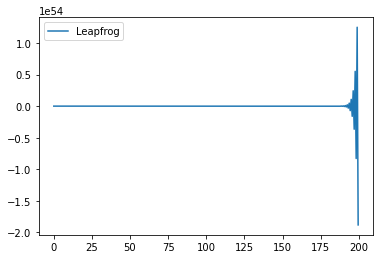

In [25]:
plt.plot(t, x_traj_lf, label='Leapfrog')
plt.legend()

As one can see, the two methods behave very differently. The oscillations slowly grow over time for Heun's method. We can also observe another effect if we look at the last 100 data points.

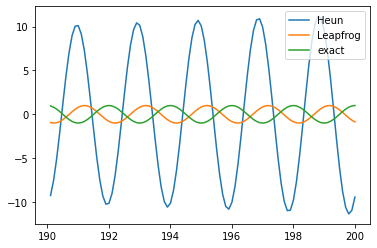

In [15]:
t = np.array(t)

plt.plot(t[-100:], x_traj_heun[-100:], label='Heun')
plt.plot(t[-100:], x_traj_lf[-100:], label='Leapfrog')
plt.plot(t[-100:], np.cos(np.pi*t[-100:]), label='exact')
plt.legend()

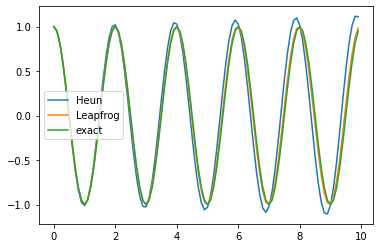

In [16]:
t = np.array(t)

plt.plot(t[:100], x_traj_heun[:100], label='Heun')
plt.plot(t[:100], x_traj_lf[:100], label='Leapfrog')
plt.plot(t[:100], np.cos(np.pi*t[:100]), label='exact')
plt.legend()

There is also a phase shift and a change in frequency for Heun's method. As for the leapfrog method, it seems that there is only a phase shift.

Finall, we may check the energy. The exact energy should be 
\begin{equation}
E = \dfrac{1}{2} \omega^2 x_0^2
\end{equation}

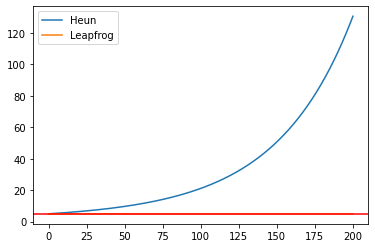

Comparing the leapfrog average energy with the exact energy, we see that they do not exactly coincide.

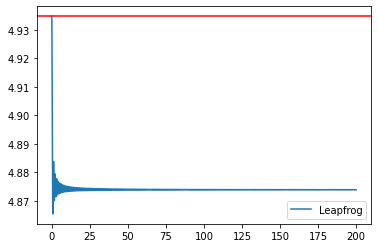

As a final note, we see that the leapfrog method itself behaves closer to the exact solution with a smaller timestep, and unstable if the step size is large enough.

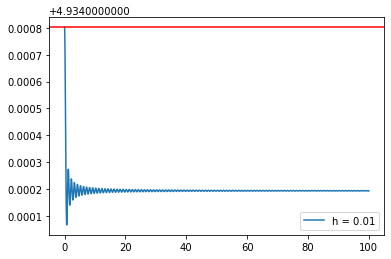

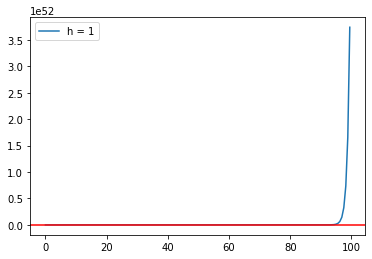

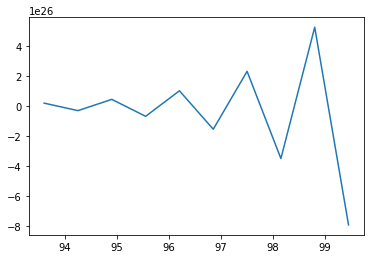

### <center> Exact discrete solution using matrix methods </center>

We wish to explain the following observations. For Heun's method,
1. The amplitude of the oscillation diverges.
2. There is a frequency and phase shift

while for the leapfrog method,
1. The amplitude remains stable below a certain value of stepsize, and diverges above a certain value of stepsize.
2. There is an observed phase shift, but little frequency shift

We shall try to explain these two observations by deriving the exact discrete solution of Heun's method and the leapfrog method.

___

It can be shown that the integration step of Heun's method may be cast as the following transformation,
\begin{equation}
x_{i+1} = \left(1 - \dfrac{1}{2} (h \omega)^2 \right) x_i + h \omega (\omega^{-1} v_i),  \qquad \omega^{-1} v_{i+1} = - h \omega x_i + \left( 1 - \dfrac{1}{2} (h \omega)^2 \right) (\omega^{-1}v_i),
\end{equation}
while the leapfrog method may be cast as the following as the following transformation,
\begin{equation}
x_{i+1} = \left( 1 - \dfrac{1}{2} (h \omega)^2 \right) x_i + h \omega (\omega^{-1} v_i), \qquad \omega^{-1} v_{i+1} = \left( - h \omega + \dfrac{1}{4} (h \omega)^3 \right) x_i + \left( 1 - \dfrac{1}{2} (h \omega)^2 \right) (\omega^{-1} v_i).
\end{equation}
We may summarize the two transformation as a matrix equation,
\begin{equation}
\begin{pmatrix}
x_{i+1} \\ \omega^{-1} v_{i+1}
\end{pmatrix} = S_H \begin{pmatrix}
x_{i} \\ \omega^{-1} v_{i}
\end{pmatrix}, \qquad \begin{pmatrix} x_{i+1} \\ \omega^{-1} v_{i+1}
\end{pmatrix} = S_{LF} \begin{pmatrix}
x_{i} \\ \omega^{-1} v_{i}
\end{pmatrix}
\end{equation}
where
\begin{equation}
S_H = \begin{pmatrix}
1 - \dfrac{1}{2} (h \omega)^2 & h \omega \\
- h \omega & 1 - \dfrac{1}{2} (h \omega)^2
\end{pmatrix}, \qquad S_{LF} = \begin{pmatrix}
 1 - \dfrac{1}{2} (h \omega)^2 & h \omega \\
- h \omega + \dfrac{1}{4} (h \omega)^3  & 1 - \dfrac{1}{2} (h \omega)^2 
\end{pmatrix}
\end{equation}
Here's the punchline: if we start at some initial condition, the exact $n$th integration step is going to be given by
\begin{equation}
\begin{pmatrix}
x_{n} \\ \omega^{-1} v_{n}
\end{pmatrix} = S_H^n \begin{pmatrix}
x_{0} \\ \omega^{-1} v_{0}
\end{pmatrix}, \qquad \begin{pmatrix} x_{n} \\ \omega^{-1} v_{n}
\end{pmatrix} = S_{LF}^n \begin{pmatrix}
x_{0} \\ \omega^{-1} v_{0}
\end{pmatrix}.
\end{equation}
Thus, to dictate the exact discrete dynamics of Heun's method and the leapfrog method, it is sufficient to calculate the $n$th power of $S_H$ and $S_{LF}$.

Moving forward, it is useful to define
\begin{equation}
A = h \omega
\end{equation}
___

Recall that the $n$th power of a matrix may be calculated whenever the eigenvalues and eigenvectors of that matrix has been calculated. Specifically, for $2\times2$ matrices with eigenvalues $\lambda_\pm$ and eigenvectors $v_\pm$, then
\begin{equation}
S^n = P D^n P^{-1}, \qquad P = \begin{pmatrix}
v_+ & v_-
\end{pmatrix}, \qquad D = \begin{pmatrix}
\lambda_+ & 0 \\
0 & \lambda_-
\end{pmatrix}
\end{equation}
___

For $S_H$, we have
\begin{equation}
\lambda_\pm = \left(1 - \dfrac{A^2}{2}\right) \mp i A, \qquad v_\pm = \begin{pmatrix}
\pm i \\ 1
\end{pmatrix}
\end{equation}

Eigenvalue: -A**2/2 - I*A + 1. Eigenvector: Matrix([[I], [1]])
Eigenvalue: -A**2/2 + I*A + 1. Eigenvector: Matrix([[-I], [1]])


It is convenient to write the eigenvalues in polar form,
\begin{equation}
\lambda_\pm = r \exp( \mp i \theta), \qquad r = \sqrt{1 + \dfrac{A^4}{4} }, \qquad \theta = \arctan\left( \dfrac{A}{1 - A^2/2} \right)
\end{equation}
This gives us the rather simple expression,
\begin{equation}
S^n_H = \begin{pmatrix}
r^n \cos (n \theta) & r^n \sin (n \theta) \\
-r^n \sin (n \theta) & r^n \cos (n \theta)
\end{pmatrix}
\end{equation}
and the exact discrete solution
\begin{equation}
x_n = x_0 r^n \cos (n \theta) + r^n \sin (n \theta) \dfrac{v_0}{\omega}, \qquad v_n = - x_0 \omega r^n \sin (n \theta) + v_0 r^n \cos (n \theta)
\end{equation}
Our analysis simplifies whenever $v_0 = 0$. We may also use $t = h n$ to get
\begin{equation}
x(t) = x_0 r^{t / h} \cos \left( \dfrac{\theta}{h}t \right), \qquad v(t) = - x_0 \omega r^{t / h} \sin \left( \dfrac{\theta}{h}t \right)
\end{equation}
Thus we identify where the two observed effects discussed come from. Since $r > 1$, the amplitude of this evolution increases. Also, for $h \ll 1$, the discretized frequency is given by
$\tilde{\omega} = \dfrac{\theta}{h} = \omega \left( 1 + \dfrac{(h\omega)^2}{6}\right)$.

Using the definition of the exponential,
\begin{equation}
\exp (x) = \lim_{n \to \infty} \left( 1 + \dfrac{x}{n} \right)^n,
\end{equation}
one should be able to show that
\begin{equation}
r^{t/h} = \exp\left( \dfrac{(h \omega)^4}{8} \dfrac{t}{h} \right)
\end{equation}

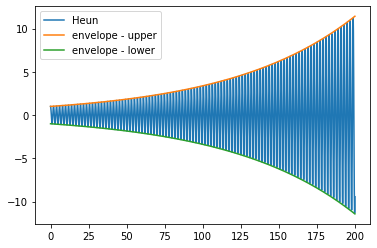

___

For $S_{LF}$, we have
\begin{equation}
\lambda_\pm = r \exp \pm i \theta, \qquad r = 1, \qquad \theta = \arccos\left(1 - \dfrac{(h \omega)^2}{2} \right)
\end{equation}
Thus, we identify why the amplitude is not affected: the magnitude of the eigenvalues, $r$, is unity! Also, we identify where the instability comes from: because $\theta = \arccos\left(1 - \dfrac{(h \omega)^2}{2} \right)$, the frequency becomes complex whenever $ \dfrac{(h \omega)^2}{2} > 1$. In our example awhile ago, $\omega = \pi$ and therefore the maximum magnitude of the stepsize is $ h < \dfrac{2}{\pi} \approx 0.63$.

We may calculate $S^n_{LF}$ using
\begin{equation}
v_\pm = \begin{pmatrix}
\pm i \\ \cos \left( \dfrac{\theta}{2} \right)
\end{pmatrix}.
\end{equation}
After much algebra, one should be able to show that
\begin{equation}
S^n_{LF} = \begin{pmatrix}
\cos n \theta, & \sin n \theta \sec \dfrac{\theta}{2} \\
-\sin n \theta \sec \dfrac{\theta}{2} & \cos n \theta
\end{pmatrix}
\end{equation}
This gives us a discrete Hamiltonian, which is conserved by the leapfrog method.
\begin{equation}
H_h(x_0, v_0) = \dfrac{1}{2} \left( \sec \dfrac{\theta}{2} v_0 \right)^2 + \dfrac{1}{2} \omega^2 x_0^2
\end{equation}

### <center> Final thoughts </center>

Whenever the acceleration is position-dependent, it is not always preferable to integrate using a energy-conserving method such as the leapfrog method. The energy-conservation comes at a very steep price: one cannot adaptively control the size of your integration step, otherwise you lose your energy conservation.

This may be seen in the harmonic oscillator case we've worked on. The discrete Hamiltonian conserved by some $h_1$ and some $h_2 \neq h_1$ is different. Every time you switch your integration step size, you will slowly drift away from the original energy surface and your integration scheme would fair no better than any other second-order method.

This becomes important whenever the dynamical timescale varies wildly. One example are highly eccentric elliptical orbits. When the orbiting mass is far away from the central mass, the acceleration is very small and one can use a larger integration step size. The opposite is true whenever the orbiting mass is near the central mass.

Thus, one better have a very good reason to use energy-conserving methods. The leapfrog method, and similar methods like it, are used whenever longterm simulations are needed to stay very close to the original energy surface such as in in silico molecular design experiments.